In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from skylark import skylark_root

df_latency = pd.read_csv(skylark_root / "profiles" / "latency.csv")
src_regions = df_latency["src_region"].unique()
dst_regions = df_latency["dst_region"].unique()

latencies = dict()
for src_region in src_regions:
    for dst_region in dst_regions:
        latency = df_latency[(df_latency["src_region"] == src_region) & (df_latency["dst_region"] == dst_region)]["avg_rtt"].mean()
        latencies[(src_region, dst_region)] = latency


df_merged = pd.read_csv(skylark_root / "profiles" / "throughput.csv")
df_merged["src_cloud"] = df_merged.src_region.str.split(":").str[0]
df_merged["dst_cloud"] = df_merged.dst_region.str.split(":").str[0]
df_merged["inter_cloud"] = df_merged.src_cloud != df_merged.dst_cloud
df_merged["throughput_received"] = df_merged["throughput_received"] / (2**30)
df_merged = df_merged[["src_region", "dst_region", "src_cloud", "dst_cloud", "inter_cloud", "throughput_received"]]
df_merged.rename(columns={"throughput_received": "throughput_gbps"}, inplace=True)

# add latency to df_merged
for index, row in df_merged.iterrows():
    if row["dst_cloud"] == "azure":
        df_merged.at[index, "latency_ms"] = latencies.get((row["dst_region"], row["src_region"]), None)
    else:
        df_merged.at[index, "latency_ms"] = latencies.get((row["src_region"], row["dst_region"]), None)
df = df_merged.dropna()
df

,src_region,dst_region,src_cloud,dst_cloud,inter_cloud,throughput_gbps,latency_ms
1,azure:germanywestcentral,aws:eu-west-2,azure,aws,True,8.730401,16.33300
2,gcp:europe-central2-a,gcp:europe-north1-a,gcp,gcp,False,6.319727,19.05800
3,gcp:europe-west4-a,azure:germanywestcentral,gcp,azure,True,6.503751,10.47250
4,gcp:us-central1-a,gcp:us-east4-a,gcp,gcp,False,6.318297,42.23525
5,gcp:europe-west3-a,aws:eu-west-1,gcp,aws,True,5.637499,23.91450
...,...,...,...,...,...,...,...
7048,aws:ap-northeast-1,gcp:europe-north1-a,aws,gcp,True,2.648411,247.86600
7049,aws:ap-northeast-3,gcp:southamerica-east1-a,aws,gcp,True,2.610008,279.33750
7050,gcp:australia-southeast1-a,gcp:europe-west1-b,gcp,gcp,False,3.301691,267.63575
7051,gcp:europe-west6-a,gcp:australia-southeast1-a,gcp,gcp,False,3.233000,212.74225


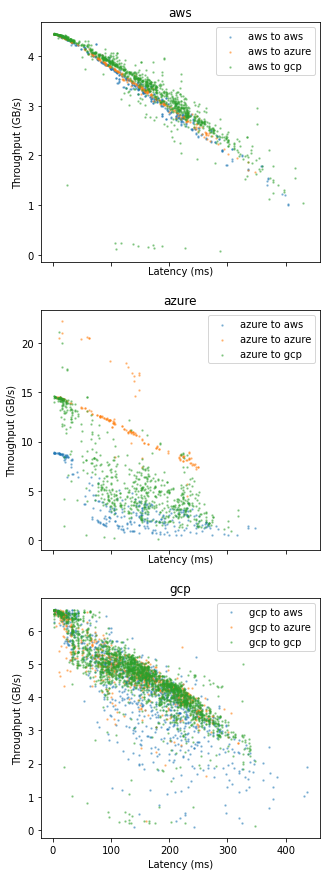

In [29]:
# plot scatter plot of latency versus throughput, color by src_cloud
fig, axs = plt.subplots(3, 1, figsize=(5, 15), sharex=True, sharey=False)
for ax, src_cloud in zip(axs, ["aws", "azure", "gcp"]):
    for dst_cloud in ["aws", "azure", "gcp"]:
        df_sub = df[(df.src_cloud == src_cloud) & (df.dst_cloud == dst_cloud)]
        ax.scatter(df_sub.latency_ms, df_sub.throughput_gbps, label=f"{src_cloud} to {dst_cloud}", alpha=0.4, s=2)
        ax.set_ylabel("Throughput (Gbps)")
        ax.set_xlabel("Latency (ms)")
        ax.set_title(f"{src_cloud}")
        ax.legend()
fig.set_facecolor("white")
fig.savefig(skylark_root / "data/figures" / "latency_vs_throughput.png", bbox_inches="tight", dpi=200)
fig.savefig(skylark_root / "data/figures" / "latency_vs_throughput.pdf", bbox_inches="tight")

Text(0, 0.5, 'Throughput (Gbps)')

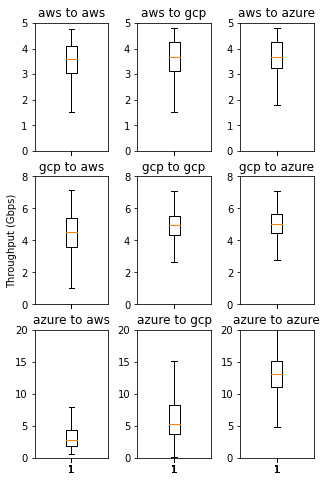

In [12]:
# plot 9 rows in one figure with one boxplot for each row
fig, ax = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(5, 8),
    sharex=True,
    # pad between rows
    gridspec_kw={"hspace": 0.2, "wspace": 0.4},
)
for i, src_cloud in enumerate(["aws", "gcp", "azure"]):
    for j, dst_cloud in enumerate(["aws", "gcp", "azure"]):
        idx = (i, j)
        ax[idx].boxplot(df[(df.src_cloud == src_cloud) & (df.dst_cloud == dst_cloud)].throughput_received / 1e9, showfliers=False)
        ax[idx].set_title(f"{src_cloud} to {dst_cloud}")
        # set scale to 0-12.5Gbps
        bw = [5, 8, 20]
        ax[idx].set_ylim(0, bw[i])
fig.patch.set_facecolor("white")
ax[1, 0].set_ylabel("Throughput (Gbps)")